<p>PokemonGo is a mobile augmented reality game developed by Niantic inc. In the game, players use mobile device's GPS capability to locate, capture and train virtual creatures, called Pokémon, who appear on the screen as if they were in the same real-world location as the player.</p>
<p>In this project, we focus on a dataset of Pokemom appearances collected by Pokemon Go. The dataset consists of roughly 293,000 records, including geological coordinates, time, weather, population density, distance to pokestops/gyms etc. as features. The aims are:</p>
<br>1. To get some rules of the distribution.</br>
<br>2. Try to build a model to predict pokemon appearances. The prediction includes three variables: time, locations, and pokemon class.</br>
<br>3. Try adding obscure features or other operations to improve prediction accuracy.</br>

## 0. Content

<p>This notebook covers these topics:</p>
1. Exploring the raw data (visualization)
2. Preparing the data
3. Discovering co-relatinship between features using Linear Regression
4. Next Steps (temporary)

## 1. Exploring the raw data (visualization)

Data for this project can be found at https://www.kaggle.com/semioniy/predictemall. After decompression, there is a file called "300k.csv" in the folder.

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
%matplotlib inline
# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)
import random

In [2]:
# load raw data
train= pd.read_csv('300k.csv')
print (train.columns.values)

['pokemonId' 'latitude' 'longitude' 'appearedLocalTime' '_id' 'cellId_90m'
 'cellId_180m' 'cellId_370m' 'cellId_730m' 'cellId_1460m' 'cellId_2920m'
 'cellId_5850m' 'appearedTimeOfDay' 'appearedHour' 'appearedMinute'
 'appearedDayOfWeek' 'appearedDay' 'appearedMonth' 'appearedYear'
 'terrainType' 'closeToWater' 'city' 'continent' 'weather' 'temperature'
 'windSpeed' 'windBearing' 'pressure' 'weatherIcon'
 'sunriseMinutesMidnight' 'sunriseHour' 'sunriseMinute'
 'sunriseMinutesSince' 'sunsetMinutesMidnight' 'sunsetHour' 'sunsetMinute'
 'sunsetMinutesBefore' 'population_density' 'urban' 'suburban' 'midurban'
 'rural' 'gymDistanceKm' 'gymIn100m' 'gymIn250m' 'gymIn500m' 'gymIn1000m'
 'gymIn2500m' 'gymIn5000m' 'pokestopDistanceKm' 'pokestopIn100m'
 'pokestopIn250m' 'pokestopIn500m' 'pokestopIn1000m' 'pokestopIn2500m'
 'pokestopIn5000m' 'cooc_1' 'cooc_2' 'cooc_3' 'cooc_4' 'cooc_5' 'cooc_6'
 'cooc_7' 'cooc_8' 'cooc_9' 'cooc_10' 'cooc_11' 'cooc_12' 'cooc_13'
 'cooc_14' 'cooc_15' 'cooc_16' 'cooc_

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are some useless columns in the file, so we can simply apply some operations to the data. Some scipts are attached with the notebook for data pre-processing. Please don't forget to concat the one-line header for processed data file. (You can do it manually or use "CAT" command).
- TERMINAL>> python findTop10.py
- TERMINAL>> python dropDistance.py


After generating these files, we can reload the data.

In [3]:
data = pd.read_csv('remove_cell2_col.csv')
print ("==================================================================================================")
# Extracting labels from the train data
train_labels = data.loc[:,'pokemonId']
print (train_labels.head())
print ("==================================================================================================")
# Extracting attributes from the train data
train_attrs = data.iloc[:,1:]
# train_attrs.drop(['appearedYear'], axis = 1, inplace = True, errors = 'ignore') ## all the data are in 2016
print (train_attrs.head())
print (train_attrs.columns.values)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0     16
1    133
2     16
3     13
4    133
Name: pokemonId, dtype: int64
    latitude   longitude    appearedLocalTime appearedTimeOfDay  appearedHour  \
0  20.525745  -97.460829  2016-09-08T03:57:45             night             5   
1  20.523695  -97.461167  2016-09-08T03:57:37             night             5   
2  38.903590  -77.199780  2016-09-08T03:57:25             night             5   
3  47.665903 -122.312561  2016-09-08T03:56:22             night             5   
4  47.666454 -122.311628  2016-09-08T03:56:08             night             5   

   appearedMinute appearedDayOfWeek  appearedDay  appearedMonth  appearedYear  \
0              57         dummy_day            8              8          2016   
1              57         dummy_day            8              8          2016   
2              57         dummy_day            8              8          2016   
3              56         dummy_day            8              8          2016   
4              56         dummy_d

In [4]:
users = pd.read_csv('top10.csv')      ##  Preprocessed Dataset
print("In total we have", train.shape[0], "traces of pokemon appearances.")

In total we have 296021 traces of pokemon appearances.


In [5]:
categorical_features = [
    'pokemonId',
    'appearedLocalTime',
    'appearedTimeOfDay',
    'appearedDayOfWeek',
    'appearedMonth',
    'terrainType',
    'closeToWater',
    'city',
    'continent',
    'weather',
    'urban', 
    'suburban', 
    'midurban', 
    'rural'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')
    
print (users.head())

  pokemonId   latitude   longitude    appearedLocalTime appearedTimeOfDay  \
0        16  20.525745  -97.460829  2016-09-08T03:57:45             night   
1       133  20.523695  -97.461167  2016-09-08T03:57:37             night   
2        16  38.903590  -77.199780  2016-09-08T03:57:25             night   
3        13  47.665903 -122.312561  2016-09-08T03:56:22             night   
4       133  47.666454 -122.311628  2016-09-08T03:56:08             night   

   appearedHour  appearedMinute appearedDayOfWeek  appearedDay appearedMonth  \
0             5              57         dummy_day            8             8   
1             5              57         dummy_day            8             8   
2             5              57         dummy_day            8             8   
3             5              56         dummy_day            8             8   
4             5              56         dummy_day            8             8   

          ...          sunsetHour sunsetMinute sunsetMin

For next step, it might be interesting to do some basic visualization.

### Appeared time of day

'appearedTimeOfDay' is a categorical feature. Its values can be night, evening, afternoon and morning. Below is the frequency of each value. 

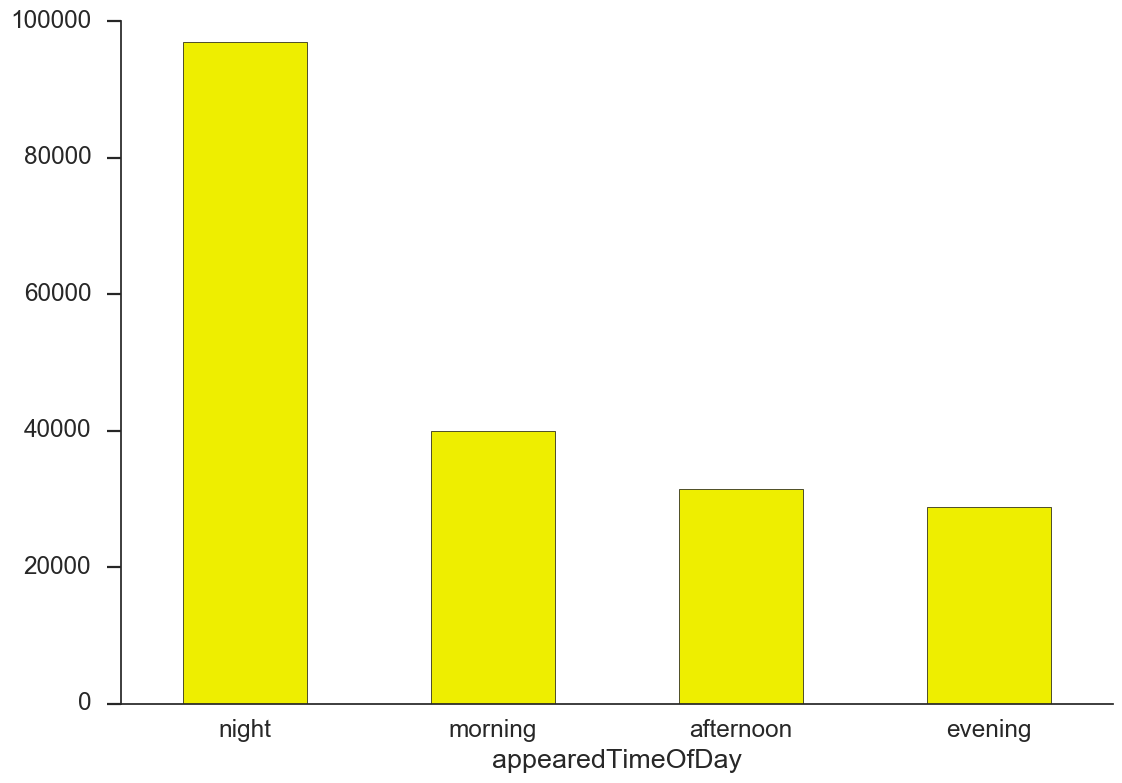

In [6]:
users.appearedTimeOfDay.value_counts()
users.appearedTimeOfDay.value_counts(dropna=False).plot(kind='bar', color='#EEEE00', rot=0)
plt.xlabel('appearedTimeOfDay')
sns.despine()

We can find that pokemons are mostly likely to appear at night. How about the exact hourly appearance? See below.

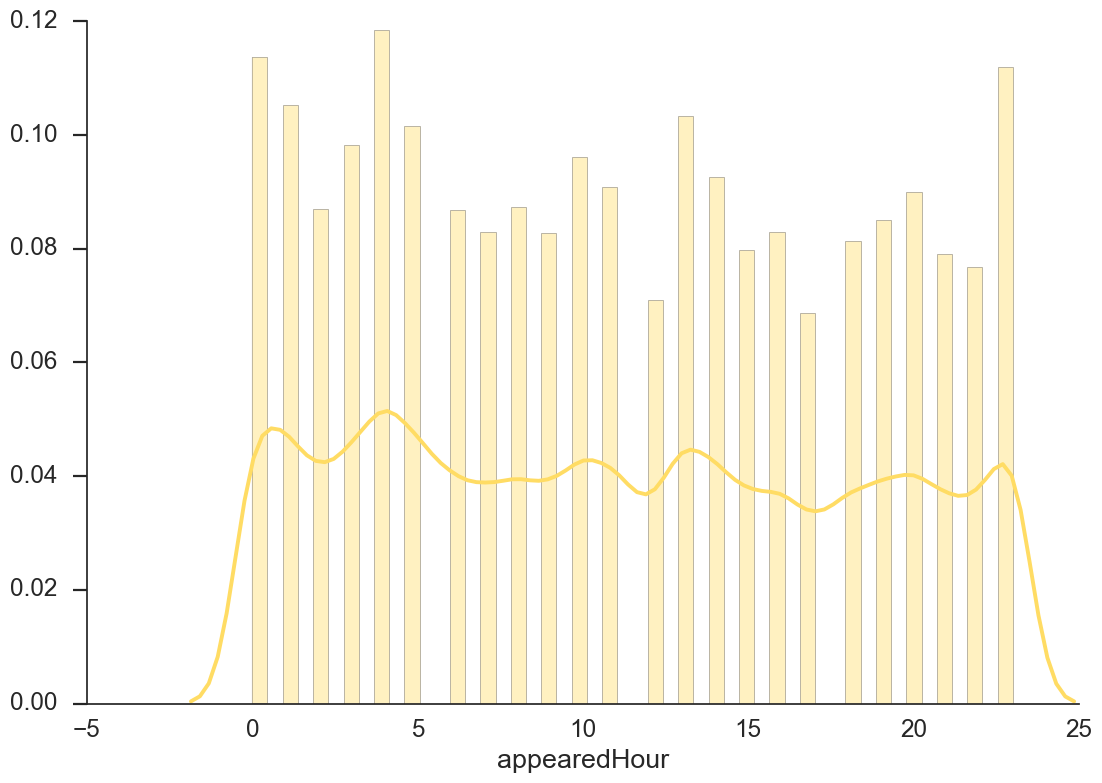

In [7]:
sns.distplot(users.appearedHour.dropna(), color='#FFDC64')
plt.xlabel('appearedHour')
sns.despine()

We simply rank the hour by appearance counts.

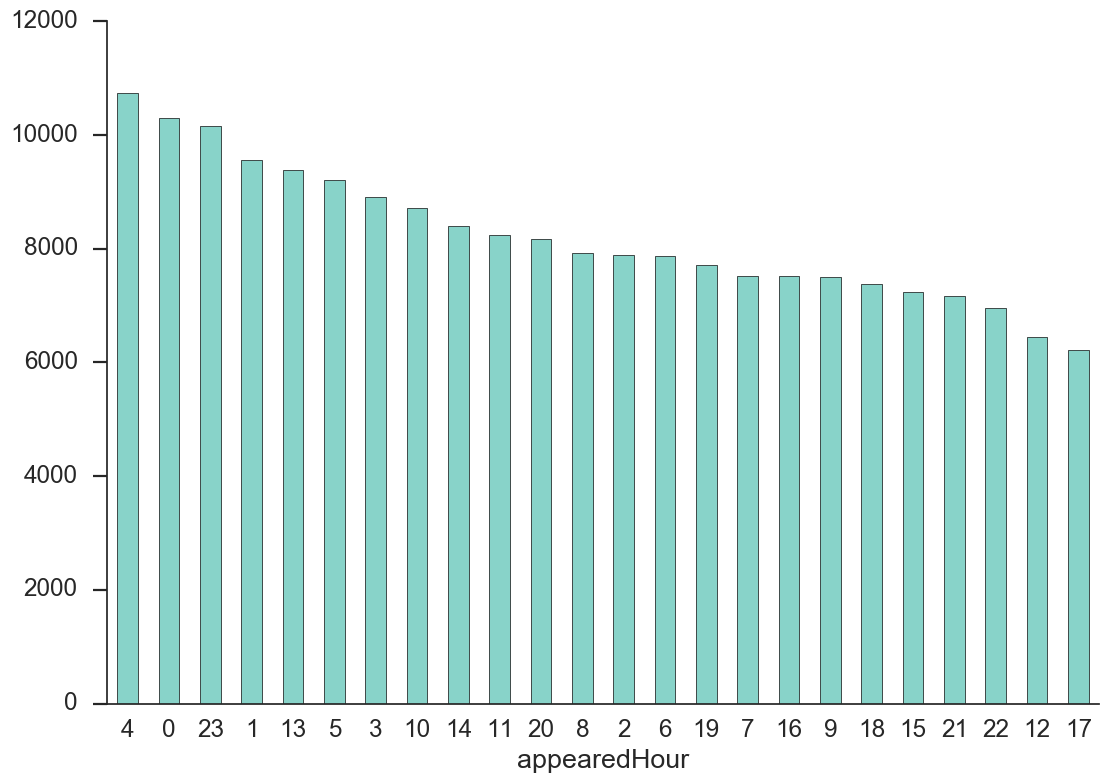

In [8]:
users.appearedHour.value_counts()
users.appearedHour.value_counts(dropna=False).plot(kind='bar', color='#88D3C9', rot=0)
plt.xlabel('appearedHour')
sns.despine()

Below is "appearedTimeOfDay" of each class of pokemon.

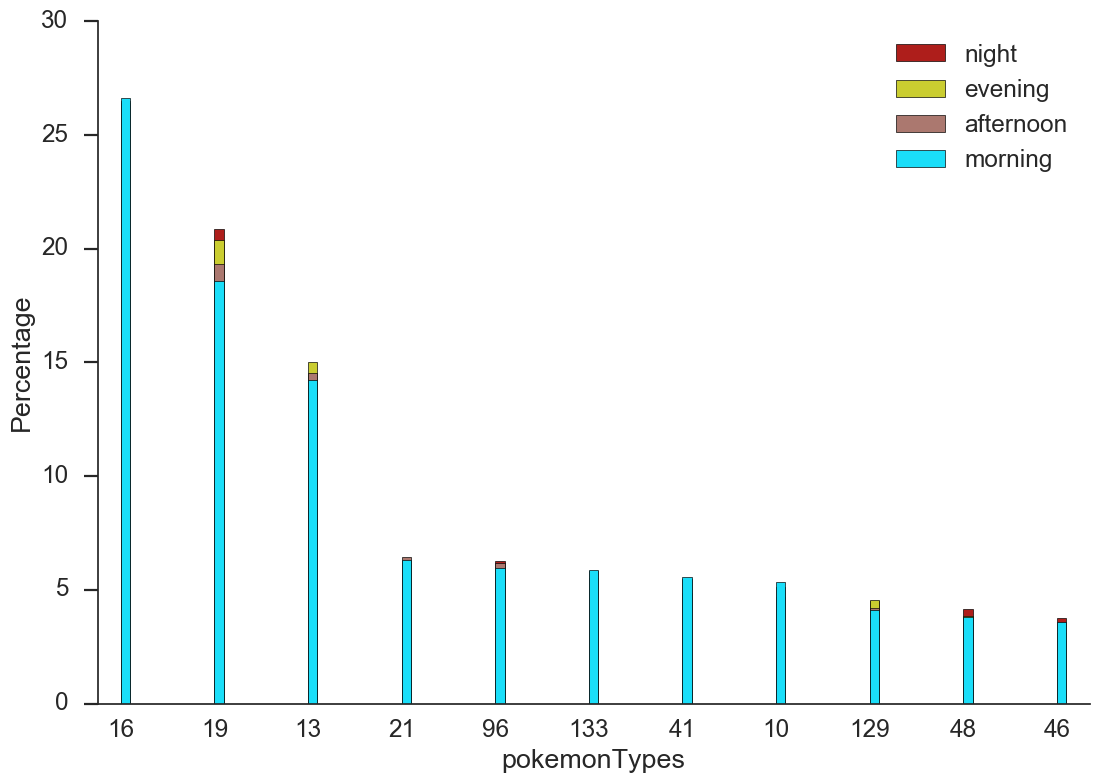

In [9]:
timeday = users["appearedTimeOfDay"].unique()

dic = {0:"0",1:"1",2:"2", 3:"3", 4:"4", 5:"5", 6:"6", 7:"7", 8:"8", 9:"9", 10:"A",11:"B",12:"C",13:"D", 14:"E", 15:"F"}

for conti in timeday:
    summ =  sum(users["appearedTimeOfDay"] == conti)
    pokemons = users.loc[users["appearedTimeOfDay"] == conti, 'pokemonId'].value_counts() / summ * 100
    width = 0.1
    colour = "#"
    for i in range(6):
        colour += dic[int(random.random() * 16)]
    pokemons.plot(kind='bar', width=width, color=colour, position=0, label=conti, rot=0)

plt.legend()
plt.xlabel('pokemonTypes')
plt.ylabel('Percentage')

sns.despine()
plt.show()

### Appeared Time of Hour

The figure below shows the pokemon appearance within each hour. The figure below shows the appearance minutes of pokemons per hour. We can see that the peaks and the counts are distributed evenly. So we can infer that pokemons are very likely to appear periodically. (10 times per hours.)

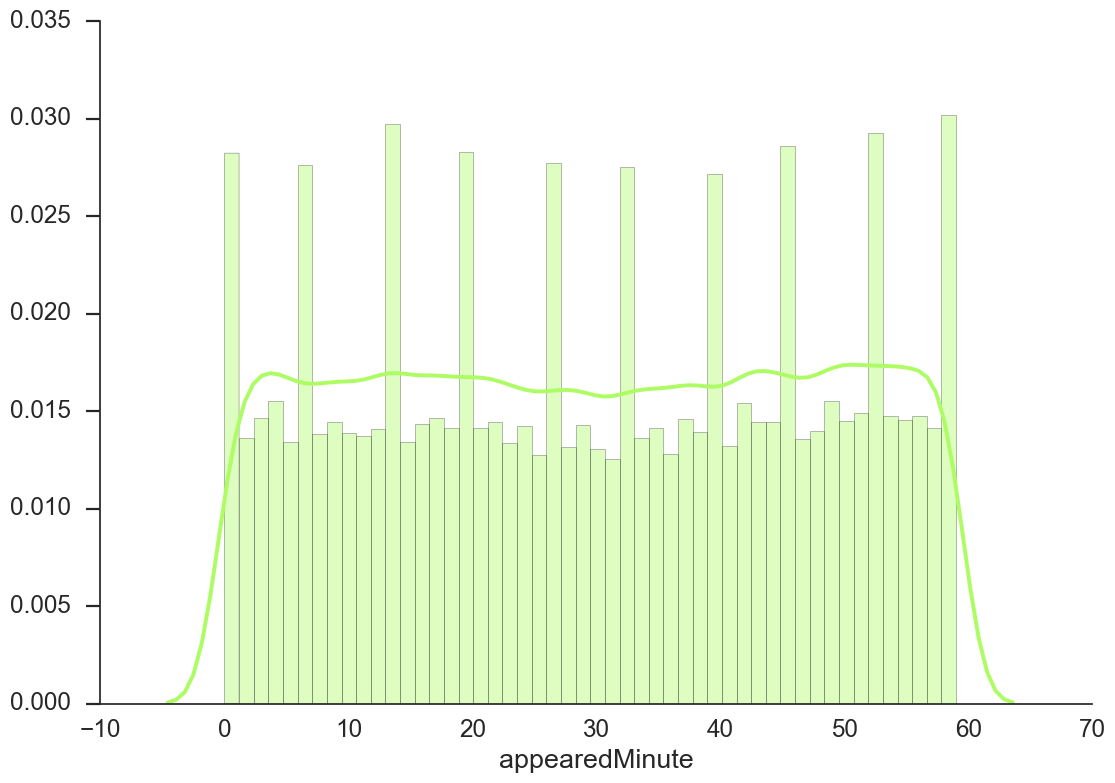

In [93]:
sns.distplot(users.appearedMinute.dropna(), color='#ADFC64')
plt.xlabel('appearedMinute')
sns.despine()

If we merge every 15 minutes into a quarter, then we can get the quarter based appearance below.

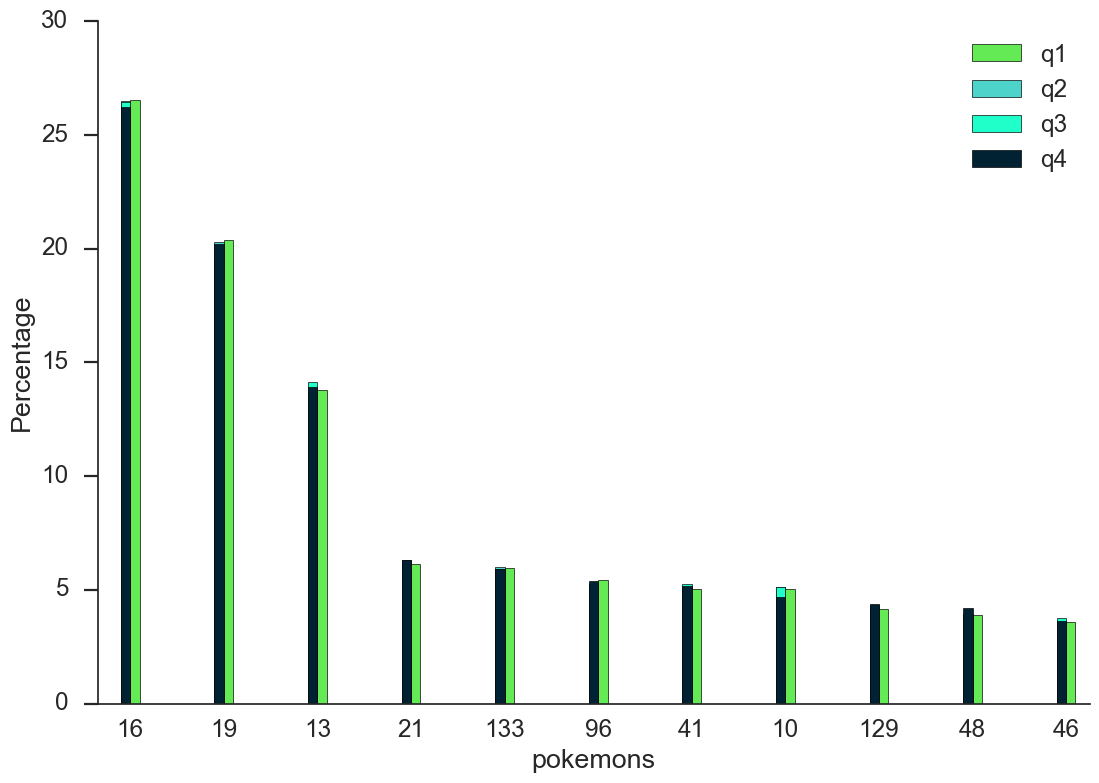

In [11]:
quarter1 = sum(users.loc[users['appearedMinute'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]), 'pokemonId'].value_counts())
quarter2 = sum(users.loc[users['appearedMinute'].isin([16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]), 'pokemonId'].value_counts())
quarter3 = sum(users.loc[users['appearedMinute'].isin([31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]), 'pokemonId'].value_counts())
quarter4 = sum(users.loc[users['appearedMinute'].isin([46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]), 'pokemonId'].value_counts())

q1_pokemons = users.loc[users['appearedMinute'].isin([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]), 'pokemonId'].value_counts() / quarter1 * 100
q2_pokemons = users.loc[users['appearedMinute'].isin([16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]), 'pokemonId'].value_counts() / quarter2 * 100
q3_pokemons = users.loc[users['appearedMinute'].isin([31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]), 'pokemonId'].value_counts() / quarter3 * 100
q4_pokemons = users.loc[users['appearedMinute'].isin([46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]), 'pokemonId'].value_counts() / quarter4 * 100

q1_pokemons.plot(kind='bar', width=width, color='#63EA55', position=0, label='q1', rot=0)
q2_pokemons.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='q2', rot=0)
q3_pokemons.plot(kind='bar', width=width, color='#20FFC9', position=1, label='q3', rot=0)
q4_pokemons.plot(kind='bar', width=width, color='#002233', position=1, label='q4', rot=0)

plt.legend()
plt.xlabel('pokemons')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Let's see which city is most popular to pokemons!

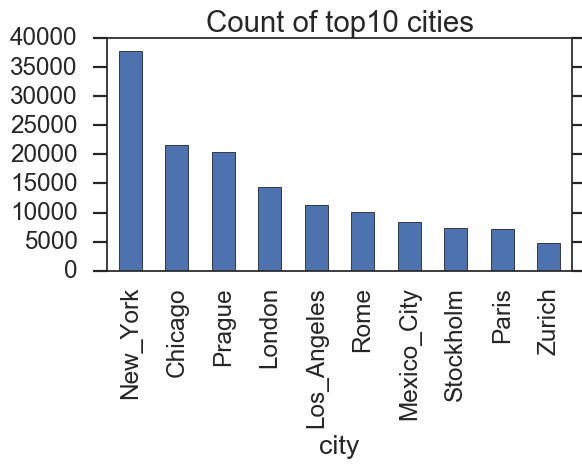

In [89]:
cnt = users.groupby('city').size()
cnt.sort_values(ascending=False)[0:10].plot(kind='bar',title='Count of top10 cities', figsize=(6,3))


How about the continent? Which is the most popular one?

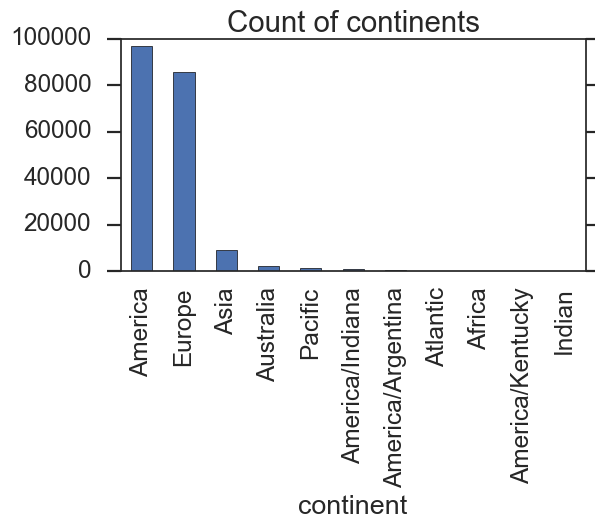

In [90]:
users.groupby('continent').size().sort_values(ascending=False).plot(kind='bar',title='Count of continents', figsize=(6,3))


## 2. Preparing the data

Below are all the features of raw data:
<table>
    <tr>
        <th>Column</th>
        <th>Data type</th> 
        <th>Description</th>
    </tr>
    <tr>
        <td>pokemonId</td>
        <td>int64</td> 
        <td>the identifier of a pokemon, should be deleted to not affect predictions</td>
    </tr>
    <tr>
        <td>latitude</td>
        <td>float64</td> 
        <td>coordinates of a sighting</td>
    </tr>
    <tr>
        <td>longitude</td>
        <td>float64</td> 
        <td>coordinates of a sighting</td>
    </tr>
    <tr>
        <td>appearedLocalTime</td>
        <td>datetime64[ns]</td> 
        <td>exact time of a sighting</td>
    </tr>
    <tr>
        <td>cellId 90-5850m</td>
        <td>float64</td> 
        <td>geographic position projected on a S2 Cell, with cell sizes ranging from 90 to 5850m</td>
    </tr>
    <tr>
        <td>appearedTimeOfDay</td>
        <td>object</td> 
        <td>time of the day of a sighting {night, evening, afternoon, morning}</td>
    </tr>
</table>

Unlike natural phenomenons or social patterns, pokemon-Go is a commercial product. So we can reasonablly wonder if there will end up being an "easy" distribution that characterizes this (after all, there is an exact model behind the generation process). To get a flavor of its distribution, let's first do linear regression to see if simple average based upon location are sufficient. Before that, we need to generate numerical features in order to perform linear regression. The feature engineering rules are as follows:

1. Time of day represented by total number of minutes elapsed in the day (cycles every 60*24 minutes, 0=midnight).
2. Binary indicator for boolean, e.g. feature weekday is 1 if the day is a weekday, and 0 otherwise.
3. windBearing: ordinal direction in degrees (so cycles every 360 degrees).

In [97]:
def load_data(fname):
    df=pd.read_csv(fname,dtype={'cellId_90m':np.float64,\
                                'cellId_180m':np.float64,'cellId_370m':np.float64,'cellId_730m':np.float64,\
                                'cellId_1460m':np.float64,'cellId_2920m':np.float64,'cellId_5850m':np.float64})
    del df['_id']
    df=df.loc[df['pokestopDistanceKm']!='?']
    df['pokestopDistanceKm']=pd.to_numeric(df['pokestopDistanceKm'],errors='raise')
    df['appearedLocalTime']=pd.to_datetime(df['appearedLocalTime'],errors='raise')
    return df
        
    
df=load_data("300k.csv")
print (df.head())


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


   pokemonId   latitude   longitude   appearedLocalTime    cellId_90m  \
0         16  20.525745  -97.460829 2016-09-08 03:57:45  9.645139e+18   
1        133  20.523695  -97.461167 2016-09-08 03:57:37  9.645139e+18   
2         16  38.903590  -77.199780 2016-09-08 03:57:25  9.923201e+18   
3         13  47.665903 -122.312561 2016-09-08 03:56:22  6.093393e+18   
4        133  47.666454 -122.311628 2016-09-08 03:56:08  6.093393e+18   

    cellId_180m   cellId_370m   cellId_730m  cellId_1460m  cellId_2920m  ...   \
0  9.645139e+18  9.645139e+18  9.645139e+18  9.645139e+18  9.645139e+18  ...    
1  9.645139e+18  9.645139e+18  9.645139e+18  9.645139e+18  9.645139e+18  ...    
2  9.923201e+18  9.923201e+18  9.923201e+18  9.923201e+18  9.923201e+18  ...    
3  6.093393e+18  6.093393e+18  6.093393e+18  6.093393e+18  6.093393e+18  ...    
4  6.093393e+18  6.093393e+18  6.093393e+18  6.093393e+18  6.093393e+18  ...    

   cooc_143 cooc_144  cooc_145  cooc_146 cooc_147  cooc_148  cooc_149  \
0

In [98]:
def create_features(df0):
    df=df0.copy()
    pi=math.pi
    # all boolean to int
    df['closeToWater']=df['closeToWater'].astype(int)
    df.iloc[:,55:206]=df.iloc[:,55:206].astype(int)  # cooc 1~151
    df[['urban','suburban','midurban','rural']]=df[['urban','suburban','midurban','rural']].astype(int)
    df[['gymIn100m','gymIn250m','gymIn500m','gymIn1000m','gymIn2500m','gymIn5000m']]=df[['gymIn100m','gymIn250m','gymIn500m','gymIn1000m','gymIn2500m','gymIn5000m']].astype(int)
    df[['pokestopIn100m','pokestopIn250m','pokestopIn500m','pokestopIn1000m','pokestopIn2500m','pokestopIn5000m']]\
    =df[['pokestopIn100m','pokestopIn250m','pokestopIn500m','pokestopIn1000m','pokestopIn2500m','pokestopIn5000m']].astype(int)
    # TimeOfDay
    coe_appearedLocalTime=2*pi/1440.0
    df['sin_appearedLocalTime']=df['appearedLocalTime'].map(lambda x:math.sin(coe_appearedLocalTime*(datetime.timedelta(0,0,0,0,x.minute,x.hour).total_seconds()/60)))
    df['cos_appearedLocalTime']=df['appearedLocalTime'].map(lambda x:math.cos(coe_appearedLocalTime*(datetime.timedelta(0,0,0,0,x.minute,x.hour).total_seconds()/60)))
    # weekday
    df['weekday']=df['appearedDayOfWeek'].map(lambda x:0 if (x=='Saturday' or x=='Sunday') else 1)
    # appearedTimeOfDay night, evening, afternoon, morning ???
    df=df.drop('appearedTimeOfDay',1)
    # appearedHour/appearedMinute - local hour/minute of a sighting (numeric)
    df=df.drop(['appearedHour','appearedMinute'],1)
    # appearedDay/appearedMonth/appearedYear - day/month/year of a sighting (numeric)
    df=df.drop(['appearedDay','appearedMonth','appearedYear'],1)
    # windBearing -- direction
    coe_windBearing=2*pi/360.0
    df['sin_windBearing']=df['windBearing'].map(lambda x:math.sin(coe_windBearing*x))
    df['cos_windBearing']=df['windBearing'].map(lambda x:math.cos(coe_windBearing*x))
    # weather/*Icon
    df=df.drop(['weather','weatherIcon'],1)
    # city
    df=df.drop('city',1)
    # continent
    df['America']=df['continent'].map(lambda x:1 if x.startswith('America') or x=='Atlantic' else 0)
    df['Australia']=df['continent'].map(lambda x:1 if x=='Australia' else 0)
    df['Europe']=df['continent'].map(lambda x:1 if x=='Europe' else 0)
    df['Asia']=df['continent'].map(lambda x:1 if x=='Asia' else 0)
    df['Pacific']=df['continent'].map(lambda x:1 if x=='Pacific' else 0)
    df['Africa']=df['continent'].map(lambda x:1 if x=='Africa' else 0)
    df['Indian']=df['continent'].map(lambda x:1 if x=='Indian' else 0)

    df=df.drop(['appearedLocalTime','appearedDayOfWeek','windBearing','continent','class','pokemonId'],1)
    df['bias']=1.0
    return df

In [99]:
df_features=create_features(df)
print ('done')

done


So far, we have finished preprocessing step. In this steps, we performed data type conversion and feature engineering.

## 3. Linear Regression

So far, we have already geenrated the features. It's time to do linear regression to see whether a simple average of location is sufficient. 

In [100]:
# America
# split training and testing
df_features_america=df_features.loc[df_features['America']==1]
size=len(df_features_america)
P=np.random.permutation(size)
split=int(size*0.7)

y_train_lat=df_features_america.iloc[P[0:split],:]['latitude']
y_train_long=df_features_america.iloc[P[0:split],:]['longitude']
X_train=df_features_america.iloc[P[0:split],:].drop(['latitude','longitude'],1)

y_test_lat=df_features_america.iloc[P[split:size],:]['latitude']
y_test_long=df_features_america.iloc[P[split:size],:]['longitude']
X_test=df_features_america.iloc[P[split:size],:].drop(['latitude','longitude'],1)

In [101]:
# Linear Regression using Ordinary Least Squares
class LR_model():
    """ Perform linear regression and predict the output on unseen examples. 
        Attributes: 
            beta (array_like) : vector containing parameters for the features """
    
    def __init__(self, X, y):
        """ Initialize the linear regression model by computing the estimate of the weights parameter
            Args: 
                X (array-like) : feature matrix of training data where each row corresponds to an example
                y (array like) : vector of training data outputs 
            """
#         L=la.cho_factor(X.T.dot(X)+1e-4*np.eye(X.shape[1]))
#         b=X.T.dot(y)
#         self.beta=la.cho_solve(L,b)
        hack=0.0001*np.eye(X.shape[1])
        self.beta=np.linalg.solve(X.T.dot(X)+hack, X.T.dot(y))
        
    def predict(self, X_p): 
        """ Predict the output of X_p using this linear model. 
            Args: 
                X_p (array_like) feature matrix of predictive data where each row corresponds to an example
            Return: 
                (array_like) vector of predicted outputs for the X_p
            """
        return X_p.dot(self.beta)


In [102]:
lr_model_lat=LR_model(X_train,y_train_lat)

lr_model_long=LR_model(X_train,y_train_long)

In [103]:
# Calculate mean squared error on both the training and validation set
def compute_mse(LR, X, y, X_v, y_v):
    """ Given a linear regression model, calculate the mean squared error for the 
        training dataset, the validation dataset, and for a mean prediction
        Args:
            LR (LR_model) : Linear model
            X (array-like) : feature matrix of training data where each row corresponds to an example
            y (array like) : vector of training data outputs 
            X_v (array-like) : feature matrix of validation data where each row corresponds to an example
            y_v (array like) : vector of validation data outputs 
        Return: 
            (train_mse, train_mean_mse, 
             valid_mse, valid_mean_mse) : a 4-tuple of mean squared errors
                                             1. MSE of linear regression on the training set
                                             2. MSE of predicting the mean on the training set
                                             3. MSE of linear regression on the validation set
                                             4. MSE of predicting the mean on the validation set
            
    """
    yp=LR.predict(X)
    train_mse=np.mean((yp-y)**2)
    yp_v=LR.predict(X_v)
    valid_mse=np.mean((yp_v-y_v)**2)
    train_mean_mse=np.mean((y-np.mean(y))**2)
    valid_mean_mse=np.mean((y_v-np.mean(y_v))**2)
    return train_mse, train_mean_mse, valid_mse, valid_mean_mse

MSE of latitude are as follows:

In [104]:
print (compute_mse(lr_model_lat,X_train,y_train_lat,X_test,y_test_lat))

(22.966262075811848, 142.06704047544673, 23.017219718533397, 141.55754961075763)


MSE of longtitude are as follows:

In [105]:
print (compute_mse(lr_model_long,X_train,y_train_long,X_test,y_test_long))

(282.13981524663092, 466.51786456418978, 257.87669374130564, 436.59951791986623)


From the results, we can see that linear regression is much better than predicting the mean of what you have seen so far. Accuracy of predicting longitude is much worse than that of latitude, because latitude ranges from 0° at the Equator to 90° (North or South), while longitude ranges from 0° at the Prime Meridian to +180° eastward and −180° westward. Latitude prediction seems fine, so our next step is to increase longitude prediction accuracy. We want to try:

1. Converting 'longitude' into absolute value and sign -1/+1.
2. Using known 'latitude' to train model. Then using predicted 'latitude' as features to predict longitude.

### Attempt 1

In attempt 1, 'longitude' is converted like this:

In [106]:
# Attempt 1
def create_features1(df0):
    df=df0.copy()
    # longitude
    df['longitude_abs']=df['longitude'].map(lambda x: abs(x) if x<0 else x)
    df['longitude_sign']=df['longitude'].map(lambda x: -1 if x<0 else 1)
    return df

In [107]:
df_features1=create_features1(df_features)
df_features1_america=df_features1.loc[df_features1['America']==1]
size1=len(df_features1_america)
P1=np.random.permutation(size1)
split1=int(size1*0.7)

y_train_long1=df_features1_america.iloc[P1[0:split1],:]['longitude']
y_train_long_abs1=df_features1_america.iloc[P1[0:split1],:]['longitude_abs']
y_train_long_sign1=df_features1_america.iloc[P1[0:split1],:]['longitude_sign']
X_train1=df_features1_america.iloc[P1[0:split1],:].drop(['latitude','longitude','longitude_abs','longitude_sign'],1)

lr_model_long_abs1=LR_model(X_train1,y_train_long_abs1)
lr_model_long_sign1=LR_model(X_train1,y_train_long_sign1)

X_test1=df_features1_america.iloc[P1[split1:size1],:].drop(['latitude','longitude','longitude_abs','longitude_sign'],1)
y_test_long1=df_features1_america.iloc[P1[split1:size1],:]['longitude']

y_p_long_abs1=lr_model_long_abs1.predict(X_test1)
y_p_long_sign1=lr_model_long_sign1.predict(X_test1)
y_p_long1=np.multiply(y_p_long_abs1,y_p_long_sign1)

train_mse1=np.mean(np.subtract(y_p_long1,y_test_long1)**2)
train_mean_mse1=np.mean((y_test_long1-np.mean(y_test_long1))**2)
print (train_mse1,train_mean_mse1)

291.398957252 452.2707575


As we can see from above results, the mse of attempt1 is 291.398957252, which is larger than original MSE 282.13981524663092. Attempt1 makes the prediction worse.

### Attempt 2

Attempt 1 didn't achieve a better result. What about attempt 2? One condition of it is that longitude is largely based on latitude. Let's see if this condition satisfies.

In [121]:
# Attempt 2
X_train_long2=df_features_america.iloc[P[0:split],:].drop(['longitude'],1) # keep 'latitude' in dataframe
X_test_long2=df_features_america.iloc[P[split:size],:].drop(['longitude',],1)
lr_model_long2=LR_model(X_train_long2,y_train_long)

print (compute_mse(lr_model_long2,X_train_long2,y_train_long,X_test_long2,y_test_long))

(271.73099551955539, 455.07970549838149, 287.8751956292578, 463.31763187231786)



As we can see from above results, the mse of attempt2 is almost the same as the original MSE, which means latitude doesn't help a lot in predicting longitude. So attempt2 is also not helpful.

## Next steps




Next steps for this problem/notebook, which can be further explore, is as follows.

- First, we would like to further optimize the linear regression model. A tentative idea is to combine the latitude and longitude into one feature, since single factor cannot achieve a better result than baseline. 

- Second, still, for the spatial features, we would like to cluster locations into several blocks (initally we will try geolocation coordinate first as our feature). We would like to see if there is a improvement of regression based on blocks of points, rather than individual points. 
  
- Finally, pokemon classification. To elaborate, given a location, given a time, give some co-appearance information, we would like to predict the pokemon label. There might be some unbalance data problems, but we will also take this part into consideration.  
